## 1 - Test avec RandomForest

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

data = pd.read_csv(r"../Datasets/EV_Energy_Consumption_Dataset.csv")

X = data.drop(["Energy_Consumption_kWh", "Timestamp", "Vehicle_ID"], axis=1)
Y = data["Energy_Consumption_kWh"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, random_state=42)

model.fit(X_train, Y_train)

Y_Pred = model.predict(X_test)

print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_Pred)}")
print(f"R2 Score: {r2_score(Y_test, Y_Pred)}")

Mean Absolute Error: 0.5166361254590908
R2 Score: 0.9129845245150148


On voit que le score R2 est déjà très bon masi on va essayer de déterminer les facteurs importants et d'améliorer ce score.

Calcul en cours (optimisation du nombre de variables)...


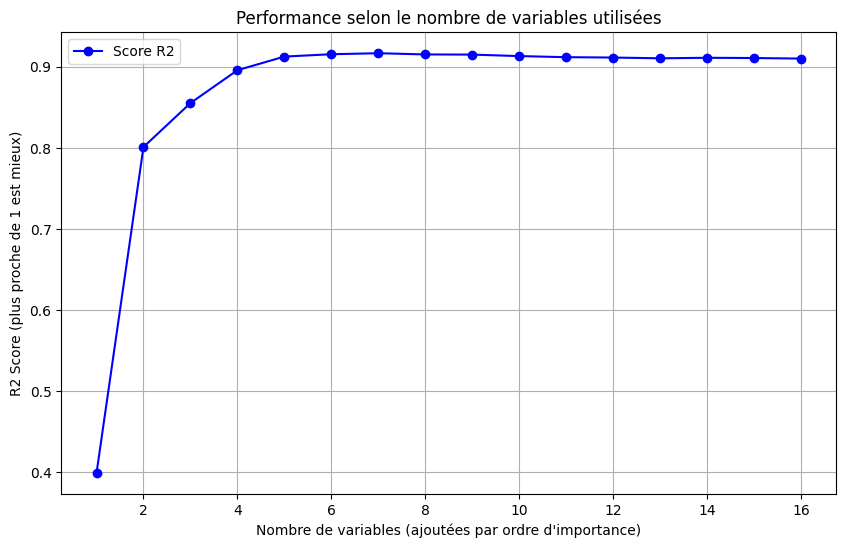


--- Top 5 des variables les plus influentes ---
1. Speed_kmh
2. Distance_Travelled_km
3. Battery_State_%
4. Humidity_%
5. Battery_Temperature_C


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import r2_score

# 1. On récupère les importances du modèle 
importances = model.feature_importances_

# 2. Préparation des Features triées (du plus important au moins important)
feature_names = X_train.columns 
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
sorted_features = feat_imp_df.sort_values(by='Importance', ascending=False)['Feature'].tolist()

# 3. Boucle d'Optimisation
scores_r2 = [] 
nums = []

print("Calcul en cours (optimisation du nombre de variables)...")

for k in range(1, len(sorted_features) + 1):
    top_k_features = sorted_features[:k]
    
    X_train_k = X_train[top_k_features]
    X_test_k = X_test[top_k_features]
    
    reg = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    reg.fit(X_train_k, Y_train)
    
    score = r2_score(Y_test, reg.predict(X_test_k))
    scores_r2.append(score)
    nums.append(k)

# 4. Graphique
plt.figure(figsize=(10, 6))
plt.plot(nums, scores_r2, marker='o', color='blue', label='Score R2')
plt.title("Performance selon le nombre de variables utilisées")
plt.xlabel("Nombre de variables (ajoutées par ordre d'importance)")
plt.ylabel("R2 Score (plus proche de 1 est mieux)")
plt.grid(True)
plt.legend()
plt.show()

# Affichage du top 5 des variables
print("\n--- Top 5 des variables les plus influentes ---")
for i, f in enumerate(sorted_features[:5], 1):
    print(f"{i}. {f}")

On voit que seul les 5 premières variables sont utiles les autre ne font que très peu varier le R2 score : On prendra donc pour la suite uniquement les 5 plus influentes.

🚀 Démarrage de l'optimisation (Correction : On garde les données brutes)...
Fenêtre 02 | R2 Score: 0.9010
Fenêtre 03 | R2 Score: 0.8983
Fenêtre 04 | R2 Score: 0.8992
Fenêtre 05 | R2 Score: 0.8952
Fenêtre 06 | R2 Score: 0.8973
Fenêtre 07 | R2 Score: 0.8998
Fenêtre 08 | R2 Score: 0.8986
Fenêtre 09 | R2 Score: 0.8991
Fenêtre 10 | R2 Score: 0.8986
Fenêtre 11 | R2 Score: 0.8989
Fenêtre 12 | R2 Score: 0.8996
Fenêtre 13 | R2 Score: 0.8995
Fenêtre 14 | R2 Score: 0.8996
Fenêtre 15 | R2 Score: 0.8996
Fenêtre 16 | R2 Score: 0.8996
Fenêtre 17 | R2 Score: 0.8996
Fenêtre 18 | R2 Score: 0.8996
Fenêtre 19 | R2 Score: 0.8996
Fenêtre 20 | R2 Score: 0.8996
🏆 MEILLEUR RÉSULTAT : Fenêtre 2 (R2 = 0.9010)


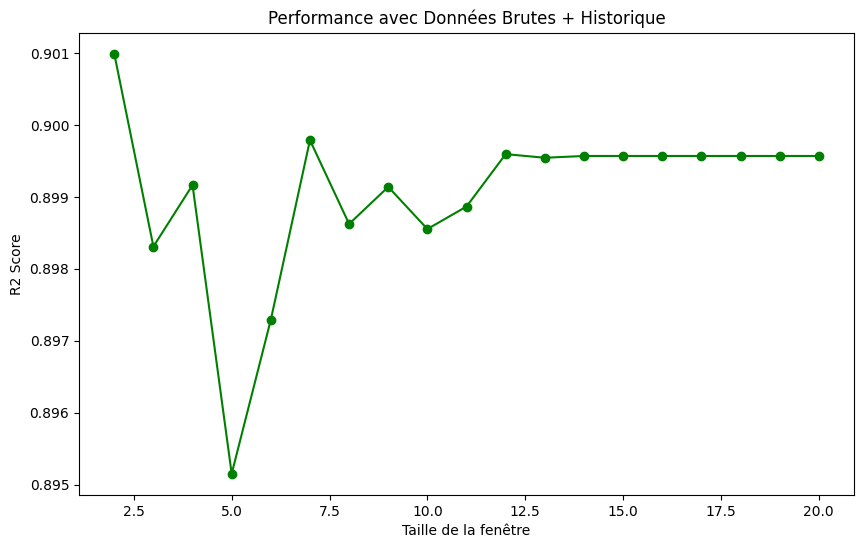

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 1. Chargement
data = pd.read_csv(r"../Datasets/EV_Energy_Consumption_Dataset.csv")

if 'Timestamp' in data.columns:
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data = data.sort_values(by=['Vehicle_ID', 'Timestamp'])

# On identifie les colonnes numériques
ignore_cols = ['Vehicle_ID', 'Timestamp', 'Energy_Consumption_kWh']
numeric_cols = [c for c in data.select_dtypes(include=np.number).columns if c not in ignore_cols]
target_col = 'Energy_Consumption_kWh'

results = {}

print("🚀 Démarrage de l'optimisation (Correction : On garde les données brutes)...")

for window_size in range(2, 21):
    
    df_features = data.copy()
    
    # Création des stats glissantes
    grouped = df_features.groupby('Vehicle_ID')[numeric_cols].rolling(window=window_size, min_periods=1)
    
    features_dict = {
        'Mean': grouped.mean(),
        'Std': grouped.std(),
        'Max': grouped.max(),
        'Min': grouped.min(),
        # On peut retirer Skew/Kurt/Var/Median pour alléger si besoin, 
        # mais gardons-les pour l'instant si tu veux tester la puissance max
        'Skew': grouped.skew(), 
    }
    
    new_cols = []
    for stat_name, stat_df in features_dict.items():
        stat_df = stat_df.reset_index(level=0, drop=True).add_suffix(f'_{stat_name}')
        new_cols.append(stat_df)
        
    df_features = pd.concat([df_features] + new_cols, axis=1)
    df_features = df_features.fillna(0)
    
    # --- CORRECTION MAJEURE ICI ---
    # On ne retire QUE les identifiants et la cible. 
    # On GARDE les numeric_cols originales (Speed, Acceleration instantanées)
    cols_to_drop = [target_col, 'Timestamp', 'Vehicle_ID'] 
    
    X = df_features.drop(cols_to_drop, axis=1, errors='ignore')
    
    # Encodage (au cas où) et nettoyage
    X = pd.get_dummies(X, drop_first=True)
    Y = df_features[target_col]
    
    # Train/Test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    # Modèle
    model = RandomForestRegressor(n_estimators=30, random_state=42, n_jobs=-1)
    model.fit(X_train, Y_train)
    
    score = r2_score(Y_test, model.predict(X_test))
    results[window_size] = score
    
    print(f"Fenêtre {window_size:02d} | R2 Score: {score:.4f}")

# Graphique final
best_window = max(results, key=results.get)
print(f"🏆 MEILLEUR RÉSULTAT : Fenêtre {best_window} (R2 = {results[best_window]:.4f})")

plt.figure(figsize=(10, 6))
plt.plot(list(results.keys()), list(results.values()), marker='o', color='green')
plt.title("Performance avec Données Brutes + Historique")
plt.xlabel("Taille de la fenêtre")
plt.ylabel("R2 Score")
plt.show()

On voit que la méthode de Faeature Engineering ne sert à rien ici et ne fait que baisser le R2 score. On va donc tenter d'améliorer le RandomForest avec des paramètres plus précis.

In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

# 1. Chargement des données brutes
data = pd.read_csv(r"../Datasets/EV_Energy_Consumption_Dataset.csv")

X = data[["Speed_kmh", "Distance_Travelled_km", "Battery_State_%", "Humidity_%", "Battery_Temperature_C"]]
X = pd.get_dummies(X, drop_first=True)
Y = data["Energy_Consumption_kWh"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 2. La Grille de Recherche (Les réglages à tester)
# On va tester plein de combinaisons différentes
param_grid = {
    'n_estimators': [100, 200, 300, 500],        # Nombre d'arbres (plus = souvent mieux mais lent)
    'max_depth': [None, 10, 20, 30],             # Profondeur max des arbres (éviter le sur-apprentissage)
    'min_samples_split': [2, 5, 10],             # Minimum d'exemples pour diviser un noeud
    'min_samples_leaf': [1, 2, 4],               # Minimum d'exemples par feuille
    'max_features': ['sqrt', 'log2', None]       # Combien de colonnes regarder à chaque division
}

print("🧠 Démarrage de l'optimisation des hyperparamètres...")
print("Cela peut prendre quelques minutes...")

rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV va tester 50 combinaisons au hasard parmi la grille
rf_random = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_grid, 
    n_iter=50,       # Nombre de tests
    cv=3,            # Validation croisée (3 tests par combinaison)
    verbose=2, 
    random_state=42, 
    n_jobs=-1        # Utilise tous les coeurs de ton processeur
)

# On lance la recherche
rf_random.fit(X_train, Y_train)

# 3. Résultats
best_model = rf_random.best_estimator_
Y_Pred = best_model.predict(X_test)

print("\n--------------------------------------------------")
print(f"Meilleurs paramètres trouvés : \n{rf_random.best_params_}")
print("--------------------------------------------------")
print(f"Nouveau R2 Score : {r2_score(Y_test, Y_Pred)}")
print(f"Nouveau MAE : {mean_absolute_error(Y_test, Y_Pred)}")

🧠 Démarrage de l'optimisation des hyperparamètres...
Cela peut prendre quelques minutes...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] E

## 2 - Test avec d'autres Models et une cross-validation

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Gestion de XGBoost
try:
    from xgboost import XGBRegressor
    xgboost_available = True
except ImportError:
    xgboost_available = False

# ==========================================
# 1. Préparation des Données
# ==========================================
print("📂 Chargement des données...")
data = pd.read_csv(r"../Datasets/EV_Energy_Consumption_Dataset.csv")

features = ["Speed_kmh", "Distance_Travelled_km", "Battery_State_%", "Humidity_%", "Battery_Temperature_C"]
target = "Energy_Consumption_kWh"

X = data[features]
Y = data[target]

# ==========================================
# 2. Configuration des Modèles
# ==========================================
models = {
    "Linear Regression": LinearRegression(),
    "SVR (Support Vector)": SVR(C=10, kernel='rbf', epsilon=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1)
}

if xgboost_available:
    models["XGBoost"] = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)

# ==========================================
# 3. La Compétition (Cross-Validation 5 Folds)
# ==========================================
print(f"\n🚀 Démarrage de la Cross-Validation (5 folds)...")
# Ajout de la colonne 'Temps'
print(f"{'Modèle':<25} | {'R2 Moyen':<10} | {'Std R2':<10} | {'MAE Moyen':<10} | {'Temps (s)':<10}")
print("-" * 80)

results = {}
time_results = {}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', model)
    ])
    
    # On récupère fit_time et score_time automatiquement
    scores = cross_validate(
        pipeline, X, Y, 
        cv=cv, 
        scoring=['r2', 'neg_mean_absolute_error'],
        n_jobs=-1
    )
    
    mean_r2 = scores['test_r2'].mean()
    std_r2 = scores['test_r2'].std()
    mean_mae = -scores['test_neg_mean_absolute_error'].mean()
    
    # Calcul du temps total moyen (Entraînement + Prédiction) par fold
    mean_time = scores['fit_time'].mean() + scores['score_time'].mean()
    
    results[name] = mean_r2
    time_results[name] = mean_time
    
    print(f"{name:<25} | {mean_r2:.4f}     | ±{std_r2:.4f}    | {mean_mae:.4f}     | {mean_time:.4f} s")

# ==========================================
# 4. Le Verdict Final
# ==========================================
best_model = max(results, key=results.get)
fastest_model = min(time_results, key=time_results.get)

print("-" * 80)
print(f"🏆 MEILLEUR SCORE  : {best_model} (R2 = {results[best_model]:.4f})")

📂 Chargement des données...

🚀 Démarrage de la Cross-Validation (5 folds)...
Modèle                    | R2 Moyen   | Std R2     | MAE Moyen  | Temps (s) 
--------------------------------------------------------------------------------
Linear Regression         | 0.9321     | ±0.0037    | 0.4523     | 0.0063 s
SVR (Support Vector)      | 0.9249     | ±0.0034    | 0.4763     | 0.9203 s
Random Forest             | 0.9156     | ±0.0021    | 0.5040     | 2.2554 s
XGBoost                   | 0.9163     | ±0.0034    | 0.5025     | 0.3656 s
--------------------------------------------------------------------------------
🏆 MEILLEUR SCORE  : Linear Regression (R2 = 0.9321)


## Code final avec enregistrement

In [ ]:
import pandas as pd
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# 1. Chargement des données
data = pd.read_csv(r"../Datasets/EV_Energy_Consumption_Dataset.csv")

# 2. On verrouille les 5 variables gagnantes
features = [
   g "Speed_kmh", 
    "Distance_Travelled_km", 
    "Battery_State_%", 
    "Humidity_%", 
    "Battery_Temperature_C"
]
target = "Energy_Consumption_kWh"

X = data[features]
Y = data[target]

# 3. Création du Pipeline (Scaler + IA)
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),      
    ('model', LinearRegression())      
])

print("🚀 Entraînement final du modèle...")
final_pipeline.fit(X, Y)

# 5. Sauvegarde dans un fichier
filename = "final_ev_model.pkl"
joblib.dump(final_pipeline, filename)

print(f"✅ C'est fait ! Le modèle est sauvegardé sous : {filename}")

🚀 Entraînement final du modèle...
✅ C'est fait ! Le modèle est sauvegardé sous : final_ev_model.pkl


## Test (facultatif)

In [19]:
import joblib
import pandas as pd

# 1. On charge le cerveau
# Assure-toi que le fichier .pkl est au même endroit
model = joblib.load("final_ev_model.pkl")

# 2. On reçoit de nouvelles données (par exemple d'une appli mobile)
# Il faut utiliser EXACTEMENT les mêmes noms de colonnes
nouvelle_donnee = pd.DataFrame([{
    "Speed_kmh": 110,                # Vitesse
    "Distance_Travelled_km": 100,    # Distance
    "Battery_State_%": 80,           # Batterie restante
    "Humidity_%": 45,                # Humidité
    "Battery_Temperature_C": 20      # Température Batterie
}])

# 3. On prédit
prediction = model.predict(nouvelle_donnee)[0]

print(f"🔮 Consommation estimée : {prediction:.2f} kWh")

🔮 Consommation estimée : 15.41 kWh
